# Install and import libraries

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import io
from collections import namedtuple, OrderedDict
import pathlib
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import random
import imageio
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf
import tensorflow_hub as tfhub

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/dataset_util.py

--2022-11-04 06:37:48--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/dataset_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2837 (2.8K) [text/plain]
Saving to: ‘dataset_util.py’

dataset_util.py     100%[===================>]   2.77K  --.-KB/s    in 0s      

2022-11-04 06:37:48 (31.1 MB/s) - ‘dataset_util.py’ saved [2837/2837]



In [ ]:
import dataset_util

# Data prepareing for train

## Convert xml to csv

In [ ]:
def xml_to_csv(path):
   xml_list = [] 
   for xml_file in glob.glob(path + '/*.xml'): 
     tree = ET.parse(xml_file) 
     root = tree.getroot() 
     for member in root.findall('object'): 
       value = (root.find('filename').text, 
                int(root.find('size')[0].text), 
                int(root.find('size')[1].text), 
                member[0].text, int(member[4][0].text), 
                int(member[4][1].text), int(member[4][2].text), 
                int(member[4][3].text))
       xml_list.append(value) 
   column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] 
   xml_df = pd.DataFrame(xml_list, columns=column_name)
   return xml_df

In [ ]:
df = xml_to_csv("/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/train")
df.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
110,126.jpg,1280,960,plate,777,621,958,699
111,127.jpg,620,440,plate,426,220,505,261
112,128.jpg,1280,720,plate,476,362,686,405
113,129.jpg,1280,738,plate,718,360,817,416
114,130.jpg,720,960,plate,510,606,644,683


In [ ]:
def change_file_tocsv():
  old_path = os.getcwd()
  print(os.getcwd())
  os.chdir("drive/MyDrive/MyDrive/Datasets/car_data_effdet")
  print(os.getcwd())
  for directory in ['train','test']:
    image_path = os.path.join(os.getcwd(), '{}'.format(directory))
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('./{}/{}_labels.csv'.format(directory, directory), index=None)
    print('Successfully converted xml to csv.')
  os.chdir("/content/")
  print(os.getcwd())

change_file_tocsv()

/content
/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet
Successfully converted xml to csv.
Successfully converted xml to csv.
/content


## Convert csv to TFrecords

In [ ]:
# Create a label map to map between label index and human-readable label name.

label_map_str = """item {
  id: 1
  name: 'plate'
}"""

with open('/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/label_map.pbtxt', 'w') as f:
  f.write(label_map_str)

# !more /contentdrive/MyDrive/MyDrive/Datasets/car_data_effdet/label_map.pbtxt/label_map.pbtxt

In [ ]:
def class_text_to_int(row_label):
    if row_label == 'plate':
      return 1
    else:
      None

In [ ]:
def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

           

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))
        
   
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [ ]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [ ]:
def create_tfrecord_file(csv_path, out_path, image_path ):
    writer = tf.io.TFRecordWriter(out_path)
    path = os.path.join(image_path)    
    examples = pd.read_csv(csv_path)    
    grouped = split(examples, 'filename')    
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), out_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


In [ ]:
csv_train = "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/train/train_labels.csv"
csv_test = "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/test/test_labels.csv"
out_tfrec_train = "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/train/train.tfrecord"
out_tfrec_test = "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/test/test.tfrecord"
train_image_path =  "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/train"
test_image_path = "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/test"

In [ ]:
create_tfrecord_file(csv_train, out_tfrec_train, train_image_path)


Successfully created the TFRecords: /content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/train/train.tfrecord


In [ ]:
create_tfrecord_file(csv_test, out_tfrec_test, test_image_path)

Successfully created the TFRecords: /content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/test/test.tfrecord


# Configure EfficientDet training configuration

## Clone the tensorflow models repository (if it doesn't already exist)

In [ ]:
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:


from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#run model builder test
# !python /content/models/research/object_detection/builders/model_builder_tf2_test.py

In [ ]:
test_record_fname = '/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/test/test.tfrecord'
train_record_fname = '/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/train/train.tfrecord'

##Change chosen model to deploy different models available in the TF2 object detection 

In [ ]:
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 4
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 4
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 4
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 4
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'

num_steps = 12000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
# num_eval_steps = 500 #Perform evaluation after so many steps
warmup_steps = 2000

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
# base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training


In [ ]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/models/research/deploy
--2022-11-04 06:40:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.33.208, 2607:f8b0:4004:837::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.33.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M   109MB/s    in 0.3s    

2022-11-04 06:40:46 (109 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



## Setup config

In [ ]:
%cp /content/models/research/deploy/efficientdet_d0_coco17_tpu-32/pipeline.config  /content/drive/MyDrive/Configs/efficientdet_d2_config

In [ ]:
#prepare
pipeline_fname = "/content/drive/MyDrive/Configs/efficientdet_d2_config/pipeline.config"
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'
num_classes = 1
label_map_pbtxt_fname = "/content/drive/MyDrive/MyDrive/Datasets/car_data_effdet/label_map.pbtxt"

In [ ]:
import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+','batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    s = re.sub('total_steps: [0-9]+',
               'total_steps: {}'.format(num_steps), s)
    
    s = re.sub('warmup_steps: [0-9]+',
               'warmup_steps: {}'.format(warmup_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)

/content/models/research/deploy
writing custom configuration file


In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

model {
  ssd {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: "ssd_efficientnet-b0_bifpn_keras"
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: SWISH
        batch_norm {
          decay: 0.9900000095367432
          scale: true
          epsilon: 0.0010000000474974513
        }
        force_use_bias: true
      }
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 1.0
        x_scale: 1.0
        height_scale: 1.0
        width_scale: 1.0

In [ ]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/plate_detect_efficientdet_model/'

## Train model 


    * pipeline_file: defined above in writing custom training configuration
    * model_dir: the location tensorboard logs and saved model checkpoints will save to
    * num_train_steps: how long to train for
    * num_eval_steps: perform eval on validation set after this many steps






In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
  --pipeline_config_path={pipeline_file} \
  --model_dir={model_dir} \
  --alsologtostderr 
  # --num_train_steps={num_steps} \
  # --sample_1_of_n_eval_examples=1 
  #  --num_eval_steps={num_eval_steps}

2022-11-02 12:01:05.794070: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 12:01:06.662664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-02 12:01:06.662881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-02 12:01:06.662909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you woul

## Export trained model

In [ ]:
output_directory = '/content/drive/MyDrive/MyDrive/Saved_Models/plate_detect_efficientdet'

#place the model weights you would like to export here
last_model_path = '/content/plate_detect_efficientdet_model/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/plate_detect_efficientdet_model/
2022-11-02 12:49:20.186465: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 12:49:21.289468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-02 12:49:21.289619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-02 12:49:21.289638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot d

In [ ]:
path = "/content/drive/MyDrive/MyDrive/Saved_Models/plate_detect/checkpoint"

## Prepare for predict

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [ ]:
# Define some utils method for prediction.

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path (this can be local or on colossus)

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(io.BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = '/content/drive/MyDrive/MyDrive/Saved_Models/plate_detect_efficientdet/checkpoint/ckpt-12'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/drive/MyDrive/MyDrive/Saved_Models/plate_detect_efficientdet/checkpoint/ckpt-12'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn


In [ ]:
detect_fn = get_model_detection_function(detection_model)

In [ ]:
pipeline_config = pipeline_file
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## Plote detections

In [ ]:
def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(10, 10),
                    min_score_thresh=0.9, image_name=None):
  image_np_with_annotations = image_np.copy() 
  image = viz_utils.visualize_boxes_and_labels_on_image_array(image_np_with_annotations, 
                                                              boxes, 
                                                              classes, 
                                                              scores, 
                                                              category_index, 
                                                              max_boxes_to_draw=20, 
                                                              min_score_thresh=min_score_thresh, 
                                                              use_normalized_coordinates=True, 
                                                              groundtruth_box_visualization_color='red') 
  plt.figure(figsize=figsize) 
  if image_name: 
      plt.imsave(image_name, image_np_with_annotations) 
  else: 
      plt.imshow(image_np_with_annotations) 
  return image


In [ ]:
%cd /content/ 

/content


In [ ]:

!wget https://raw.githubusercontent.com/Asikpalysik/Automatic-License-Plate-Detection/main/TEST/TEST2.png

--2022-11-04 09:57:30--  https://raw.githubusercontent.com/Asikpalysik/Automatic-License-Plate-Detection/main/TEST/TEST2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3748365 (3.6M) [image/png]
Saving to: ‘TEST2.png’

TEST2.png           100%[===================>]   3.57M  --.-KB/s    in 0.02s   

2022-11-04 09:57:31 (214 MB/s) - ‘TEST2.png’ saved [3748365/3748365]



In [ ]:
!pwd

/content


## Predictions

[0.6174774  0.0269343  0.02224954 0.02054209 0.01636688 0.01248682
 0.01095806 0.01009549 0.00988111 0.00959003 0.00950111 0.00921818
 0.0090785  0.00906785 0.00885412 0.00862605 0.00851392 0.00848413
 0.00838221 0.00834167 0.00828109 0.00827048 0.00823495 0.00822215
 0.00793304 0.00760333 0.00755424 0.00726491 0.00678269 0.00652358
 0.00646127 0.00637859 0.00606783 0.00600635 0.00599401 0.00594824
 0.00589852 0.00581374 0.00562586 0.0055874  0.0055755  0.00552965
 0.00522126 0.00521803 0.00521412 0.00519025 0.00517852 0.00515625
 0.00510319 0.00509657 0.00506103 0.00503706 0.00502678 0.00501058
 0.00500444 0.00494417 0.00492521 0.00489608 0.00482254 0.00477171
 0.00474075 0.00467389 0.00464389 0.00463969 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

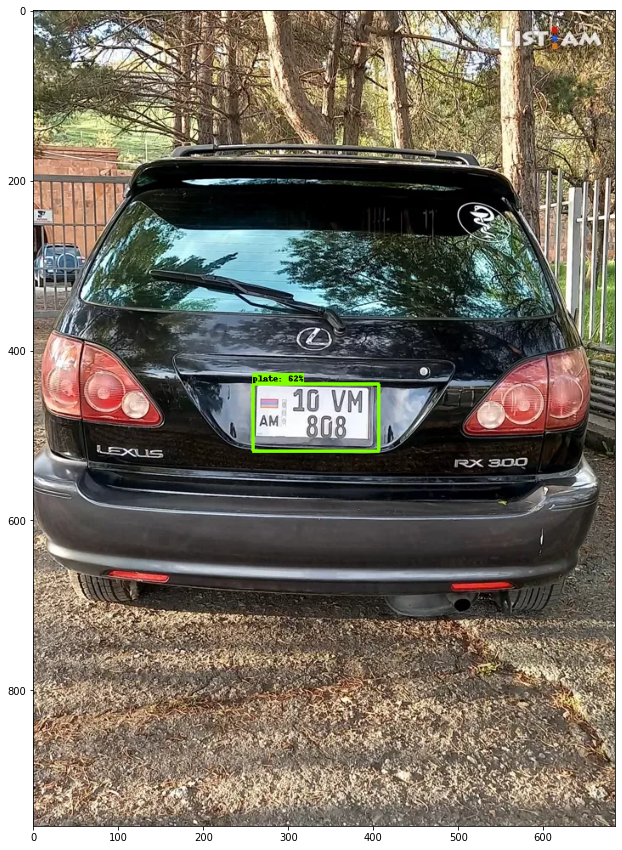

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/drive/MyDrive/MyDrive/Datasets/project_dl/Car_images/Lexus/*.jpg')
test1_path =  '/content/TEST2.png'
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)


# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)
label_id_offset = 1
image_np_with_detections = image_np.copy()


image_det = plot_detections(image_np_with_detections,
                    detections['detection_boxes'][0].numpy(),
                    (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
                    detections['detection_scores'][0].numpy(),
                    category_index,
                    image_name=None,
                    figsize=(15,15),
                    min_score_thresh=0.3)

image_det.shape
# print(detections['num_detections'][0].numpy().astype(np.int32))
# print(detections['detection_boxes'][0].numpy())
print(detections['detection_scores'][0].numpy())



[0.45927972 0.37802327 0.5405366  0.5945029 ]


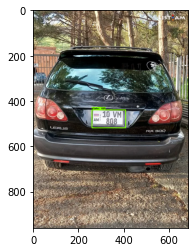

In [ ]:
boxes = detections['detection_boxes'][0].numpy()
min_score_thresh = 0.2
scores = detections['detection_scores'][0].numpy()
for i in range(boxes.shape[0]):
  if scores[i] > min_score_thresh:
      box = np.array(boxes[i])
      # box = np.unique(box)
print(box)
plt.imshow(image_det)

440 518 258 407
(78, 149, 3)


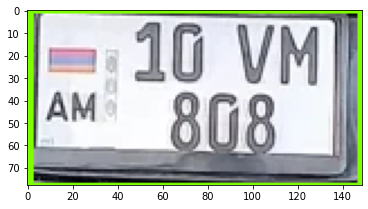

In [ ]:
height = image_det.shape[1]
width = image_det.shape[0]
ymin = int(box[0] * width)
xmin = int(box[1]* height)
ymax = int(box[2] * width)
xmax =int(box [3] * height)
print(ymin, ymax, xmin, xmax)
crop_image = image_det[ymin:ymax, xmin:xmax]
plt.imshow(crop_image)
print(crop_image.shape)

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
esrgan_model = tfhub.load(SAVED_MODEL_PATH)

In [ ]:
fake_image = esrgan_model( tf.expand_dims(tf.cast( crop_image, dtype=tf.float32), 0))
super_resolution_image = tf.squeeze(fake_image)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)


<dtype: 'float32'>


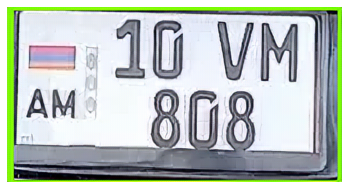

In [ ]:
plot_image(super_resolution_image)
print(super_resolution_image.dtype)

# OCR

In [ ]:
!pip install keras-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras_ocr
pipeline = keras_ocr.pipeline.Pipeline()

r_img = super_resolution_image.numpy()
image = [keras_ocr.tools.read(r_img)]
predict= pipeline.recognize(image)
# print(predict)
text=''
for txt in predict[0]:
  # print("At: ",txt)
  text+=str(txt[0])
print(text)


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step
10vman800
